In [6]:
import transformers
import torch
import pandas as pd
import huggingface_hub
import pickle

from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer, BartForSequenceClassification, PreTrainedTokenizerFast, BartForConditionalGeneration
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from transformers import get_scheduler

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file='tokenizer.json')

In [9]:
class ConversationDataset(Dataset):
    def __init__(self):
        self.data = pd.read_csv('conv_data.csv', encoding='utf-8', index_col=0)
        self.tokenizer = AutoTokenizer.from_pretrained('gogamza/kobart-base-v2')
        self.emo_code = pd.read_csv('emotion_code.csv', encoding='utf-8', index_col=0)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        train_data = tokenizer(f"<s>{self.data.iloc[index]['conversation']}</s>", return_tensors='pt', truncation=True, padding="max_length", max_length=300)
        train_data['label'] = torch.tensor(self.emo_code[self.emo_code['code'] == self.data.iloc[index]['emotion']].index[0])
        return train_data.to("cuda")

In [10]:
dataset = ConversationDataset()

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [11]:
train, val = train_test_split(dataset, test_size=0.2, random_state=42)
val, test = train_test_split(val, test_size=0.5, random_state=42)

In [12]:
train_dataset = DataLoader(train, batch_size=4, shuffle=True)
val_dataset = DataLoader(val, batch_size=4)
test_dataset = DataLoader(test, batch_size=4)

In [13]:
class LyricEmotionClassifier:
    def __init__(self):
        self.model = BartForSequenceClassification.from_pretrained('gogamza/kobart-base-v2', num_labels=60).to("cuda")
        self.optimizer = AdamW(self.model.parameters(), lr=5e-5)
        self.lr_scheduler = get_scheduler(
            name="linear",
            optimizer=self.optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_dataset),
        )
        
    def model_train(self):
        self.model.train()
        self.total_train_loss = 0
        
        for batch in tqdm(train_dataset):
            input_ids = batch['input_ids'].to(device).squeeze()
            attention_mask = batch['attention_mask'].to(device).squeeze()
            labels = batch['label'].to(device)
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            self.total_train_loss += loss.item()

            # 역전파
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

        avg_train_loss = self.total_train_loss / len(train_dataset)
        print(f"training loss: {avg_train_loss}")

In [14]:
bart1 = LyricEmotionClassifier()
bart1.model.load_state_dict(torch.load('bart_lyric.pt'))

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at gogamza/kobart-base-v2 and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [15]:
with open('emotion_code.pkl', 'rb') as file:
    emo_list = pickle.load(file)

In [16]:
emo_list

[{'idx': 0, 'code': 'E10', 'emotion': '분노'},
 {'idx': 1, 'code': 'E11', 'emotion': '툴툴대는'},
 {'idx': 2, 'code': 'E12', 'emotion': '좌절한'},
 {'idx': 3, 'code': 'E13', 'emotion': '짜증내는'},
 {'idx': 4, 'code': 'E14', 'emotion': '방어적인'},
 {'idx': 5, 'code': 'E15', 'emotion': '악의적인'},
 {'idx': 6, 'code': 'E16', 'emotion': '안달하는'},
 {'idx': 7, 'code': 'E17', 'emotion': '구역질나는'},
 {'idx': 8, 'code': 'E18', 'emotion': '노여워하는'},
 {'idx': 9, 'code': 'E19', 'emotion': '성가신'},
 {'idx': 10, 'code': 'E20', 'emotion': '슬픔'},
 {'idx': 11, 'code': 'E21', 'emotion': '실망한'},
 {'idx': 12, 'code': 'E22', 'emotion': '비통한'},
 {'idx': 13, 'code': 'E23', 'emotion': '후회되는'},
 {'idx': 14, 'code': 'E24', 'emotion': '우울한'},
 {'idx': 15, 'code': 'E25', 'emotion': '마비된'},
 {'idx': 16, 'code': 'E26', 'emotion': '염세적인'},
 {'idx': 17, 'code': 'E27', 'emotion': '눈물이나는'},
 {'idx': 18, 'code': 'E28', 'emotion': '낙담한'},
 {'idx': 19, 'code': 'E29', 'emotion': '환멸을느끼는'},
 {'idx': 20, 'code': 'E30', 'emotion': '불안'},
 {'idx': 2

In [17]:
emo_list1 = [{row['idx']: {'code': row['code'], 'emotion': row['emotion']} } for row in emo_list]

In [18]:
emo_list1

[{0: {'code': 'E10', 'emotion': '분노'}},
 {1: {'code': 'E11', 'emotion': '툴툴대는'}},
 {2: {'code': 'E12', 'emotion': '좌절한'}},
 {3: {'code': 'E13', 'emotion': '짜증내는'}},
 {4: {'code': 'E14', 'emotion': '방어적인'}},
 {5: {'code': 'E15', 'emotion': '악의적인'}},
 {6: {'code': 'E16', 'emotion': '안달하는'}},
 {7: {'code': 'E17', 'emotion': '구역질나는'}},
 {8: {'code': 'E18', 'emotion': '노여워하는'}},
 {9: {'code': 'E19', 'emotion': '성가신'}},
 {10: {'code': 'E20', 'emotion': '슬픔'}},
 {11: {'code': 'E21', 'emotion': '실망한'}},
 {12: {'code': 'E22', 'emotion': '비통한'}},
 {13: {'code': 'E23', 'emotion': '후회되는'}},
 {14: {'code': 'E24', 'emotion': '우울한'}},
 {15: {'code': 'E25', 'emotion': '마비된'}},
 {16: {'code': 'E26', 'emotion': '염세적인'}},
 {17: {'code': 'E27', 'emotion': '눈물이나는'}},
 {18: {'code': 'E28', 'emotion': '낙담한'}},
 {19: {'code': 'E29', 'emotion': '환멸을느끼는'}},
 {20: {'code': 'E30', 'emotion': '불안'}},
 {21: {'code': 'E31', 'emotion': '두려운'}},
 {22: {'code': 'E32', 'emotion': '스트레스받는'}},
 {23: {'code': 'E33', 'emoti

In [19]:
def eval_emo(model, lyrics):
    model.eval()
    lyrics = lyrics.replace("\n", ' ').strip()
    inputs = tokenizer(lyrics, return_tensors="pt", padding=True, truncation=True, max_length=700)
    # print(inputs)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prob = torch.nn.functional.softmax(outputs[0], dim=1).squeeze().detach().cpu().numpy()
        label = torch.argsort(outputs[0], descending=True).squeeze().detach().cpu().numpy()
        print(sorted(prob, reverse=True)[:10])
        for code in label[:10]:
            print(emo_list[code]['emotion'], end=' ')
        print()
    return prob

In [20]:
input_text = """
이제 괜찮니 너무 힘들었잖아
우리 그 마무리가 고작 이별뿐인 건데
우린 참 어려웠어
잘 지낸다고 전해 들었어 가끔
벌써 참 좋은 사람
만나 잘 지내고 있어
굳이 내게 전하더라
잘했어 넌 못 참았을 거야
그 허전함을 견뎌 내기엔
좋으니 사랑해서 사랑을 시작할 때
니가 얼마나 예쁜지 모르지
그 모습을 아직도 못 잊어
헤어 나오지 못해
니 소식 들린 날은 더
좋으니 그 사람 솔직히 견디기 버거워
니가 조금 더 힘들면 좋겠어
진짜 조금 내 십 분의 일 만이라도
아프다 행복해줘
억울한가 봐 나만 힘든 것 같아
나만 무너진 건가
고작 사랑 한번 따위 나만 유난 떠는 건지
복잡해 분명 행복 바랬어
이렇게 빨리 보고 싶을 줄
좋으니 사랑해서 사랑을 시작할 때
니가 얼마나 예쁜지 모르지
그 모습을 아직도 못 잊어
헤어 나오지 못해
니 소식 들린 날은 더
좋으니 그 사람 솔직히 견디기 버거워
너도 조금 더 힘들면 좋겠어
진짜 조금 내 십 분의 일 만이라도
아프다 행복해줘
혹시 잠시라도 내가 떠오르면
걘 잘 지내 물어 봐줘
잘 지내라고 답할 걸 모두 다
내가 잘 사는 줄 다 아니까
그 알량한 자존심 때문에
너무 잘 사는 척
후련한 척 살아가
좋아 정말 좋으니
딱 잊기 좋은 추억 정도니
난 딱 알맞게 사랑하지 못한
뒤끝 있는 너의 예전 남자친구일 뿐
스쳤던 그저 그런 사랑
"""

In [21]:
def extract_base_emotions(result):
    
    base_emotion = {
        'Joy': 0,
        'Sadness': 0,
        'Anger': 0,
        'Fear': 0,
        'Surprise': 0,
        'Disgust': 0
    }

    for idx, value in enumerate(result):
        if (idx + 10 in [60, 61, 62, 63, 64, 65, 68, 69]):
            base_emotion['Joy'] += value
        elif (idx + 10 in [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 42, 43, 45, 46, 47, 48, 49, 41, 53, 54, 55, 56, 58]):
            base_emotion['Sadness'] += value
        elif (idx + 10 in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 41, 47]):
            base_emotion['Anger'] += value
        elif (idx + 10 in [20, 31, 32, 33, 34, 35, 36, 37, 38, 39]):
            base_emotion['Fear'] += value
        elif (idx + 10 in [40, 44, 41, 52, 59]):
            base_emotion['Surprise'] += value
        else:
            base_emotion['Disgust'] += value
    base_emotion = sorted(base_emotion.items(), key=lambda x: x[1], reverse=True)
    return base_emotion


In [22]:
result = eval_emo(bart1.model, f'<s>{input_text}</s>')
result

[0.3911912, 0.2607739, 0.031042127, 0.029929116, 0.015961634, 0.014405242, 0.012031182, 0.010788272, 0.01077206, 0.0102854]
염세적인 억울한 희생된 가난하고불우한 방어적인 마비된 우울한 괴로워하는 질투하는 슬픔 


c:\Users\Harvey\anaconda3\envs\ml_dl\lib\site-packages\transformers\models\bart\modeling_bart.py:497: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


array([0.00332393, 0.00914259, 0.00805922, 0.01023348, 0.01596163,
       0.00445847, 0.00665936, 0.00383082, 0.00600869, 0.00509434,
       0.0102854 , 0.00201668, 0.01000897, 0.00693928, 0.01203118,
       0.01440524, 0.3911912 , 0.00523112, 0.00464799, 0.00928647,
       0.00145961, 0.00094278, 0.00310661, 0.00825991, 0.00255938,
       0.00147088, 0.00539455, 0.00708109, 0.00410784, 0.00244217,
       0.00988924, 0.01077206, 0.00490868, 0.00383979, 0.00113492,
       0.02992912, 0.03104213, 0.2607739 , 0.01078827, 0.00526968,
       0.00256467, 0.00113336, 0.00280148, 0.00177719, 0.00881364,
       0.00151393, 0.0029147 , 0.00294598, 0.00159997, 0.00255163,
       0.00180003, 0.00225255, 0.00280867, 0.00216958, 0.00367531,
       0.00286846, 0.00386469, 0.00203145, 0.00117893, 0.00474515],
      dtype=float32)

In [23]:
df = pd.read_csv('song_data_clean.csv', sep=',', encoding='utf-8', index_col=0)
df

,genre,title,artist,lyric
0,"발라드, 국내드라마",내 손을 잡아,아이유,느낌이 오잖아 떨리고 있잖아 언제까지 눈치만 볼 거니 네 맘을 말해봐 딴청 피우지 ...
1,발라드,Timeless,SG 워너비,어쩜 살아가다 보면 한 번은 날 찾을지 몰라 난 그 기대 하나로 오늘도 힘겹게 버틴...
2,"발라드, 국내영화",희재,성시경,햇살은 우릴 위해 내리고 바람도 서롤 감싸게 했죠 우리 웃음속에 계절은 오고 또 갔...
3,발라드,거리에서,성시경,니가 없는 거리에는 내가 할일이 없어서 마냥 걷다 걷다보면 추억을 가끔 마주치지 떠...
4,발라드,라라라,SG 워너비,그대는 참 아름다워요 밤 하늘의 별빛보다 빛나요 지친 나의 마음을 따뜻하게 감싸줄 ...
...,...,...,...,...
95,발라드,한번 더 이별,성시경,뒤돌아 보면 너의 생각을 떠올린 게 언제였더라 숨 가쁘게 사는 건 무디게 했어 끝나...
96,발라드,좋은사람,박효신,좋은사람 준비없이 비를 만난것처럼 아무말 못한채 너를 보낸뒤에 한동안 취한 새벽에 ...
97,발라드,잘가요 내사랑,에이트,안녕 잘 지내니 귀엽던 니 얼굴은 예전과 같은지 조금 늦은 안부 늦은 이별을 담아 ...
98,발라드,너를 위해,임재범,어쩜 우린 복잡한 인연에 서로 엉켜있는 사람인가봐 나는 매일 네게 갚지도 못할만큼 ...


In [24]:
for idx in range(len(df)):
    print(f"{df.iloc[idx]['artist']} : {df.iloc[idx]['title']}")
    result = eval_emo(bart1.model, f"<s>{df.iloc[idx]['lyric']}</s>")
    base_emotion = extract_base_emotions(result)
    print(*base_emotion)
    print("--------------------------------------------------")

아이유 : 내 손을 잡아
[0.09738874, 0.0926013, 0.05262103, 0.043179367, 0.04087047, 0.03171719, 0.028127413, 0.02794767, 0.027697887, 0.027094252]
방어적인 남의시선을의식하는 툴툴대는 짜증내는 조심스러운 두려운 마비된 환멸을느끼는 악의적인 성가신 
('Anger', 0.316128037404269) ('Sadness', 0.3112357647623867) ('Fear', 0.1759922131896019) ('Surprise', 0.1042697171214968) ('Disgust', 0.061157055431976914) ('Joy', 0.03121720312628895)
--------------------------------------------------
SG 워너비 : Timeless
[0.6081846, 0.07638767, 0.06125437, 0.02873571, 0.027284106, 0.024792664, 0.017232528, 0.016178763, 0.012326938, 0.011571595]
자신있는 신뢰하는 느긋 만족스러운 편안한 감사하는 기쁨 흥분 안도 신이난 
('Joy', 0.8103676158934832) ('Disgust', 0.07842274545691907) ('Sadness', 0.05811978760175407) ('Anger', 0.023787179263308644) ('Fear', 0.023208892671391368) ('Surprise', 0.006093673291616142)
--------------------------------------------------
성시경 : 희재
[0.11754532, 0.074304156, 0.05857739, 0.054490592, 0.033063345, 0.032885674, 0.030691627, 0.0279758, 0.027861949, 0.025798421]
질투하는

In [25]:
df1 = pd.read_csv('conv_data.csv', index_col=0)
df1

,conversation,emotion
0,일은 왜 해도 해도 끝이 없을까? 화가 난다. 많이 힘드시겠어요. 주위에 의논할 상...,E18
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....,E18
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,E18
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,E18
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나. 무시하는 것 같...,E18
...,...,...
51623,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고....,E19
51624,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나. 건강...,E39
51625,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정...,E46
51626,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가...,E37


In [26]:
aa = df1['emotion'].value_counts()
aa

emotion
E37    1229
E13    1054
E24    1002
E27     993
E31     991
E47     984
E18     975
E32     971
E19     969
E20     958
E10     958
E48     953
E22     950
E45     949
E40     937
E11     926
E58     918
E42     911
E44     910
E23     906
E34     901
E43     901
E51     900
E39     899
E56     897
E41     896
E28     896
E30     893
E29     884
E55     883
E17     882
E12     875
E16     873
E52     872
E21     870
E59     870
E38     869
E53     865
E33     864
E49     861
E36     860
E50     859
E54     859
E15     845
E35     842
E46     840
E25     838
E57     833
E26     828
E14     803
E60     660
E64     655
E67     639
E68     634
E61     631
E62     609
E63     597
E69     570
E66     568
E65     563
Name: count, dtype: int64

In [27]:
base_emotion_count = {
    'Joy': 0,
    'Sadness': 0,
    'Anger': 0,
    'Fear': 0,
    'Surprise': 0,
    'Disgust': 0
}

for idx, value in zip(aa.index, aa):
    idx = int(idx[1:])
    if (idx in [60, 61, 62, 63, 64, 65, 68, 69]):
        base_emotion_count['Joy'] += value
    elif (idx in [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 42, 43, 45, 46, 47, 48, 49, 41, 53, 54, 55, 56, 58]):
        base_emotion_count['Sadness'] += value
    elif (idx in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 41, 47]):
        base_emotion_count['Anger'] += value
    elif (idx in [20, 31, 32, 33, 34, 35, 36, 37, 38, 39]):
        base_emotion_count['Fear'] += value
    elif (idx in [40, 44, 41, 52, 59]):
        base_emotion_count['Surprise'] += value
    else:
        base_emotion_count['Disgust'] += value

In [28]:
base_emotion_count

{'Joy': 4919,
 'Sadness': 21779,
 'Anger': 9160,
 'Fear': 8426,
 'Surprise': 2652,
 'Disgust': 4692}

In [29]:
import matplotlib.pyplot as plt

In [30]:
emotions = []
counts = []
for e, c in base_emotion_count.items():
    emotions.append(e)
    counts.append(c)

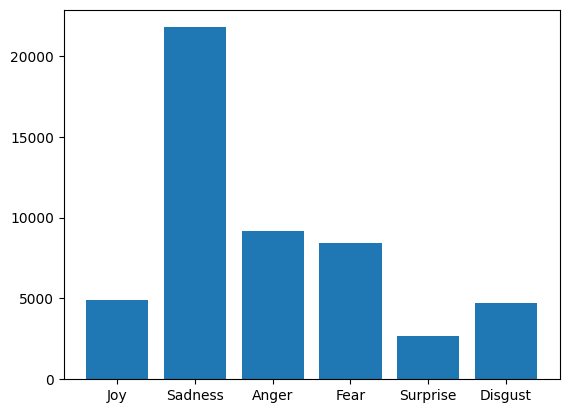

In [31]:
plt.bar(emotions, counts)
plt.show()

In [32]:
lyrics = """
이제 괜찮니 너무 힘들었잖아
우리 그 마무리가 고작 이별뿐인 건데
우린 참 어려웠어
잘 지낸다고 전해 들었어 가끔
벌써 참 좋은 사람
만나 잘 지내고 있어
굳이 내게 전하더라
잘했어 넌 못 참았을 거야
그 허전함을 견뎌 내기엔
좋으니 사랑해서 사랑을 시작할 때
니가 얼마나 예쁜지 모르지
그 모습을 아직도 못 잊어
헤어 나오지 못해
니 소식 들린 날은 더
좋으니 그 사람 솔직히 견디기 버거워
니가 조금 더 힘들면 좋겠어
진짜 조금 내 십 분의 일 만이라도
아프다 행복해줘
억울한가 봐 나만 힘든 것 같아
나만 무너진 건가
고작 사랑 한번 따위 나만 유난 떠는 건지
복잡해 분명 행복 바랬어
이렇게 빨리 보고 싶을 줄
좋으니 사랑해서 사랑을 시작할 때
니가 얼마나 예쁜지 모르지
그 모습을 아직도 못 잊어
헤어 나오지 못해
니 소식 들린 날은 더
좋으니 그 사람 솔직히 견디기 버거워
너도 조금 더 힘들면 좋겠어
진짜 조금 내 십 분의 일 만이라도
아프다 행복해줘
혹시 잠시라도 내가 떠오르면
걘 잘 지내 물어 봐줘
잘 지내라고 답할 걸 모두 다
내가 잘 사는 줄 다 아니까
그 알량한 자존심 때문에
너무 잘 사는 척
후련한 척 살아가
좋아 정말 좋으니
딱 잊기 좋은 추억 정도니
난 딱 알맞게 사랑하지 못한
뒤끝 있는 너의 예전 남자친구일 뿐
스쳤던 그저 그런 사랑
"""

In [33]:
lyrics = lyrics.replace("\n", ' ').strip()
lyrics = '<s>' + lyrics + '</s>'
inputs = tokenizer(lyrics, return_tensors="pt", padding=True, truncation=True, max_length=700)
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

In [34]:
class ExtractFeatureFromLyric:
    def __init__(self):
        self.model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-summarization')
        self.tokenizer = AutoTokenizer.from_pretrained('./')

In [35]:
feature_extractor = ExtractFeatureFromLyric()
feature_extractor.model.to(device)
a = feature_extractor.model.generate(input_ids, max_length=30)
tokenizer.decode(a.squeeze().tolist(), skip_special_tokens=True)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


'우리 그 마무리가 고작 이별뿐인 건데 우린 참 어려웠어 잘 지낸다고 전해 들었어 가끔 벌써 참 좋은 사람 만나'

In [36]:
while True:
    text = input("가사를 입력해주세요.")
    if text == 'quit':
        break
    else:
        text = text.replace("\n", ' ').strip()
        text = '<s>' + text + '</s>'
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=700)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        a = feature_extractor.model.generate(input_ids, max_length=20)
        text = ""
        print(tokenizer.decode(a.squeeze().tolist(), skip_special_tokens=True))

In [37]:
class GeneratePromptFromLyric:
    pass

In [39]:
df

,genre,title,artist,lyric
0,"발라드, 국내드라마",내 손을 잡아,아이유,느낌이 오잖아 떨리고 있잖아 언제까지 눈치만 볼 거니 네 맘을 말해봐 딴청 피우지 ...
1,발라드,Timeless,SG 워너비,어쩜 살아가다 보면 한 번은 날 찾을지 몰라 난 그 기대 하나로 오늘도 힘겹게 버틴...
2,"발라드, 국내영화",희재,성시경,햇살은 우릴 위해 내리고 바람도 서롤 감싸게 했죠 우리 웃음속에 계절은 오고 또 갔...
3,발라드,거리에서,성시경,니가 없는 거리에는 내가 할일이 없어서 마냥 걷다 걷다보면 추억을 가끔 마주치지 떠...
4,발라드,라라라,SG 워너비,그대는 참 아름다워요 밤 하늘의 별빛보다 빛나요 지친 나의 마음을 따뜻하게 감싸줄 ...
...,...,...,...,...
95,발라드,한번 더 이별,성시경,뒤돌아 보면 너의 생각을 떠올린 게 언제였더라 숨 가쁘게 사는 건 무디게 했어 끝나...
96,발라드,좋은사람,박효신,좋은사람 준비없이 비를 만난것처럼 아무말 못한채 너를 보낸뒤에 한동안 취한 새벽에 ...
97,발라드,잘가요 내사랑,에이트,안녕 잘 지내니 귀엽던 니 얼굴은 예전과 같은지 조금 늦은 안부 늦은 이별을 담아 ...
98,발라드,너를 위해,임재범,어쩜 우린 복잡한 인연에 서로 엉켜있는 사람인가봐 나는 매일 네게 갚지도 못할만큼 ...


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

lyrics = [lyric for lyric in df['lyric']]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lyrics)
vectorizer.get_feature_names_out()

array(['39', '5분만', 'about', ..., '힘에', '힘을', '힘이'], dtype=object)

In [92]:
X

<100x4781 sparse matrix of type '<class 'numpy.float64'>'
	with 8534 stored elements in Compressed Sparse Row format>

In [137]:
first_song = X.getrow(1)

In [97]:
vectorizer.vocabulary_
a = list(vectorizer.vocabulary_.items())
idx_to_voca = {}

for (voca, idx) in a:
    idx_to_voca[idx] = voca

In [98]:
idx_to_voca

{1115: '느낌이',
 3415: '오잖아',
 1470: '떨리고',
 3806: '있잖아',
 3224: '언제까지',
 1105: '눈치만',
 279: '거니',
 1667: '맘을',
 1651: '말해봐',
 1408: '딴청',
 4421: '피우지',
 1606: '말란',
 1625: '말이야',
 155: '가는',
 500: '그대로',
 4091: '지금',
 2710: '손을',
 3912: '잡아',
 3200: '어서',
 3503: '우연히',
 390: '고개를',
 1253: '돌릴',
 1504: '마다',
 1099: '눈이',
 1534: '마주치는',
 1754: '며칠',
 912: '내내',
 745: '꿈속에',
 835: '나타나',
 2053: '밤새',
 799: '나를',
 448: '괴롭히는',
 1592: '많은',
 2327: '빈자리',
 4077: '중에서',
 4500: '하필',
 3370: '옆자릴',
 394: '고르는',
 791: '나도',
 1764: '모르게',
 3152: '어느새',
 2842: '실없는',
 3570: '웃음',
 4750: '흘리고',
 3780: '있다는',
 556: '그럼',
 1166: '다했지',
 3488: '우리',
 3133: '얘기',
 4545: '할까',
 4587: '핸드폰',
 4172: '진동에',
 2853: '심장이',
 1232: '덜컥내려',
 3053: '앉는다는',
 4184: '짓궂은',
 1632: '말투',
 3848: '자꾸',
 1369: '듣고',
 2871: '싶은걸',
 3179: '어떡해',
 3928: '저기',
 1717: '멀리',
 337: '걸어온다',
 1537: '마주친다',
 1779: '모른척',
 4541: '할거니',
 2409: '사랑이',
 3419: '온거야',
 988: '너와',
 1005: '네가',
 4010: '좋아',
 3971: '정말',
 373: '견딜',
 1587:

In [138]:
print(first_song)

  (0, 799)	0.03749309353611016
  (0, 3220)	0.15756869603444082
  (0, 2512)	0.08585713579313342
  (0, 2198)	0.05191337777291937
  (0, 2112)	0.17171427158626684
  (0, 4242)	0.15756869603444082
  (0, 1806)	0.10382675554583874
  (0, 642)	0.1397473784653275
  (0, 4442)	0.15756869603444082
  (0, 3391)	0.10641218126590696
  (0, 4758)	0.15756869603444082
  (0, 2106)	0.15756869603444082
  (0, 664)	0.08585713579313342
  (0, 4032)	0.07878434801722041
  (0, 3069)	0.07878434801722041
  (0, 979)	0.0737661252288776
  (0, 433)	0.08585713579313342
  (0, 2479)	0.0737661252288776
  (0, 4292)	0.08585713579313342
  (0, 2575)	0.06400438833717519
  (0, 789)	0.08585713579313342
  (0, 959)	0.13440263015958528
  (0, 3834)	0.11924109935410322
  (0, 3294)	0.12800877667435037
  (0, 2301)	0.1397473784653275
  :	:
  (0, 304)	0.08585713579313342
  (0, 1526)	0.057782678668407944
  (0, 1221)	0.07878434801722041
  (0, 902)	0.04484058999700637
  (0, 4299)	0.07878434801722041
  (0, 300)	0.12335022932924358
  (0, 1149)	0.0

In [140]:
result = []
for voca, score in zip(first_song.indices, sorted(first_song.data, reverse=True)):
    result.append({idx_to_voca[voca] : score})
print(result[:5])

[{'나를': 0.22129837568663283}, {'어쩜': 0.17171427158626684}, {'살아가다': 0.17171427158626684}, {'보면': 0.17171427158626684}, {'번은': 0.17171427158626684}]
